### Project 1

#### Part A

Jerônimo de Abreu Afrange

- Select 30 stocks in the S&P 500 universe
- Collect daily returns for the past 10 years (2014-2023)
- Create both value-weighted and equally weighted portfolio
- Rebalance these portfolios in the first day of the month based on the information on the last day (1-day lag)
- Which portfolio has the highest turnover?
- Compute daily returns for both portfolios
- Compute the following statistics for these portfolios:
    - Annualized average return
    - Annualized standar deviation
    - Sharpe ratio
    - Information ratio (vs S&P500)
- Plot cumulative returns for both portfolios, S&P500 and risk-free




In [2]:
import pandas as pd
import dateutil.relativedelta

from matplotlib import pyplot as plt

In [3]:
# AUXILIARY FUNCTIONS

# calculates the month number
def month_number(date, start_date):
    delta = dateutil.relativedelta.relativedelta(date, start_date)
    return delta.years * 12 + delta.months

In [4]:
# DATA LOADING AND INITIAL MANIPULATION

# creates the DataFrames for de S&P500 index and de stock prices
stocks_data = pd.read_csv("../data/stock_prices.csv")
index_data = pd.read_csv("../data/sp500_index.csv")

# removes the stocks of which we don't have data from 2014 to the current day
incomplete_stocks = stocks_data["Ticker"].value_counts()
incomplete_stocks = incomplete_stocks[incomplete_stocks < incomplete_stocks.max()]
stocks_data = stocks_data[~stocks_data["Ticker"].isin(incomplete_stocks.index)]

In [5]:
# CREATION OF THE MONTH NUMBER COLUMN

# creation of the month number column
stocks_data["Date"] = pd.to_datetime(stocks_data["Date"])
stocks_data["MONTH_NUMBER"] = stocks_data["Date"].apply(lambda x: month_number(x, stocks_data["Date"].min()))

# defines a few constants
INITIAL_DATE = stocks_data["Date"].min()
INITIAL_PORT_VALUE = 1e6

In [7]:
# CREATION OF THE VALUE WEIGHTED PORTFOLIO

# creates the porfolio DataFrame, which is a copy of the current stocks_data DataFrame
portfolio_vw = stocks_data.copy()

# convenience variables
initial_date_filter = portfolio_vw["Date"] == INITIAL_DATE

# creation of the column for the total market cap of the stocks and column of the share of the total
portfolio_vw["TOTAL_MKT_CAP"] = portfolio_vw.groupby("Date")["CUR_MKT_CAP"].transform("sum")
portfolio_vw["MKT_CAP_SHARE"] = portfolio_vw["CUR_MKT_CAP"] / portfolio_vw["TOTAL_MKT_CAP"]

# creation of the initial porfolio stock ammount for each stock and propagation to the entire DataFrame
portfolio_vw.loc[initial_date_filter, "PORT_STOCK_AMT"] = INITIAL_PORT_VALUE * portfolio_vw["MKT_CAP_SHARE"] / portfolio_vw["PX_OPEN"]
stock_amounts = portfolio_vw.loc[initial_date_filter, ["Ticker", "PORT_STOCK_AMT"]]
portfolio_vw = portfolio_vw.drop(columns="PORT_STOCK_AMT")
portfolio_vw = portfolio_vw.merge(stock_amounts, on="Ticker")

# calculation of the values of the individual positions as well as the total portfolio value
portfolio_vw["PORT_STOCK_VAL_LAST"] = portfolio_vw["PX_LAST"] * portfolio_vw["PORT_STOCK_AMT"]
portfolio_vw["PORT_TOTAL_VAL_LAST"] = portfolio_vw.groupby("Date")["PORT_STOCK_VAL_LAST"].transform("sum")

# creates a copy of the current portfolio for future comparison
portfolio_vw_unbalanced = portfolio_vw.copy()

# rebalancing loop
for i in range(1, portfolio_vw["MONTH_NUMBER"].max() + 1):

    # convenience filters
    ending_date_filter = portfolio_vw["Date"] == portfolio_vw[portfolio_vw["MONTH_NUMBER"] == i - 1]["Date"].max()
    initial_date_filter = portfolio_vw["Date"] == portfolio_vw[portfolio_vw["MONTH_NUMBER"] == i]["Date"].min()
    current_month_filter = portfolio_vw["MONTH_NUMBER"] >= i
    
    # rebalancing of the number of shares and propagation to the rest of the DataFrame
    current_portfolio_value = portfolio_vw[ending_date_filter]["PORT_TOTAL_VAL_LAST"].iloc[0]
    portfolio_vw.loc[initial_date_filter, "PORT_STOCK_AMT"] = current_portfolio_value * portfolio_vw["MKT_CAP_SHARE"] / portfolio_vw["PX_OPEN"]
    stock_amounts = portfolio_vw.loc[initial_date_filter, ["Ticker", "PORT_STOCK_AMT"]]
    stock_amounts["MONTH_NUMBER"] = i
    portfolio_vw = pd.merge(portfolio_vw, stock_amounts, on=["Ticker", "MONTH_NUMBER"], how="left", suffixes=("", "_new"))
    portfolio_vw["PORT_STOCK_AMT"] = portfolio_vw["PORT_STOCK_AMT_new"].combine_first(portfolio_vw["PORT_STOCK_AMT"])
    portfolio_vw.drop(columns=["PORT_STOCK_AMT_new"], inplace=True)

    # calculating the new portfolio values
    portfolio_vw.loc[current_month_filter, "PORT_STOCK_VAL_LAST"] = portfolio_vw["PX_LAST"] * portfolio_vw["PORT_STOCK_AMT"]
    portfolio_vw.loc[current_month_filter, "PORT_TOTAL_VAL_LAST"] = portfolio_vw.groupby("Date")["PORT_STOCK_VAL_LAST"].transform("sum")

portfolio_vw["PORT_SHARE"] = portfolio_vw["PORT_STOCK_VAL_LAST"] / portfolio_vw["PORT_TOTAL_VAL_LAST"]

In [13]:
# CREATION OF THE EQUALLY WEIGHTED PORTFOLIO

# creates the porfolio DataFrame, which is a copy of the current stocks_data DataFrame
portfolio_ew = stocks_data.copy()

# convenience variables
initial_date_filter = portfolio_ew["Date"] == INITIAL_DATE

# creation of the initial porfolio stock ammount for each stock and propagation to the entire DataFrame
number_of_companies = portfolio_ew["Ticker"].nunique()
portfolio_ew.loc[initial_date_filter, "PORT_STOCK_AMT"] = INITIAL_PORT_VALUE / number_of_companies / portfolio_ew["PX_OPEN"]
stock_amounts = portfolio_ew.loc[initial_date_filter, ["Ticker", "PORT_STOCK_AMT"]]
portfolio_ew = portfolio_ew.drop(columns="PORT_STOCK_AMT")
portfolio_ew = portfolio_ew.merge(stock_amounts, on="Ticker")

# calculation of the values of the individual positions as well as the total portfolio value
portfolio_ew["PORT_STOCK_VAL_LAST"] = portfolio_ew["PX_LAST"] * portfolio_ew["PORT_STOCK_AMT"]
portfolio_ew["PORT_TOTAL_VAL_LAST"] = portfolio_ew.groupby("Date")["PORT_STOCK_VAL_LAST"].transform("sum")

# creates a copy of the current portfolio for future comparison
portfolio_ew_unbalanced = portfolio_ew.copy()

# rebalancing loop
for i in range(1, portfolio_ew["MONTH_NUMBER"].max() + 1):

    # convenience filters
    ending_date_filter = portfolio_ew["Date"] == portfolio_ew[portfolio_ew["MONTH_NUMBER"] == i - 1]["Date"].max()
    initial_date_filter = portfolio_ew["Date"] == portfolio_ew[portfolio_ew["MONTH_NUMBER"] == i]["Date"].min()
    current_month_filter = portfolio_ew["MONTH_NUMBER"] >= i
    
    # rebalancing of the number of shares and propagation to the rest of the DataFrame
    current_portfolio_value = portfolio_ew[ending_date_filter]["PORT_TOTAL_VAL_LAST"].iloc[0]
    portfolio_ew.loc[initial_date_filter, "PORT_STOCK_AMT"] = current_portfolio_value / number_of_companies / portfolio_ew["PX_OPEN"]
    stock_amounts = portfolio_ew.loc[initial_date_filter, ["Ticker", "PORT_STOCK_AMT"]]
    stock_amounts["MONTH_NUMBER"] = i
    portfolio_ew = pd.merge(portfolio_ew, stock_amounts, on=["Ticker", "MONTH_NUMBER"], how="left", suffixes=("", "_new"))
    portfolio_ew["PORT_STOCK_AMT"] = portfolio_ew["PORT_STOCK_AMT_new"].combine_first(portfolio_ew["PORT_STOCK_AMT"])
    portfolio_ew.drop(columns=["PORT_STOCK_AMT_new"], inplace=True)

    # calculating the new portfolio values
    portfolio_ew.loc[current_month_filter, "PORT_STOCK_VAL_LAST"] = portfolio_ew["PX_LAST"] * portfolio_ew["PORT_STOCK_AMT"]
    portfolio_ew.loc[current_month_filter, "PORT_TOTAL_VAL_LAST"] = portfolio_ew.groupby("Date")["PORT_STOCK_VAL_LAST"].transform("sum")

portfolio_ew["PORT_SHARE"] = portfolio_ew["PORT_STOCK_VAL_LAST"] / portfolio_ew["PORT_TOTAL_VAL_LAST"]

In [15]:
portfolio_ew[portfolio_ew["Date"] == portfolio_ew[portfolio_ew["MONTH_NUMBER"] == 1]["Date"].min()]

,Date,PX_LAST,PX_OPEN,PX_HIGH,PX_LOW,PX_VOLUME,CUR_MKT_CAP,Ticker,MONTH_NUMBER,PORT_STOCK_AMT,PORT_STOCK_VAL_LAST,PORT_TOTAL_VAL_LAST,PORT_SHARE
21,2014-02-03,69.9900,72.6600,72.7300,69.8500,11966489.0,122472.5124,DIS,1,513.361047,35930.139665,980578.966616,0.036642
2691,2014-02-03,78.6800,81.6800,82.2500,78.5100,988665.0,7741.1808,UHS,1,456.670099,35930.803364,980578.966616,0.036642
5361,2014-02-03,28.3630,29.5090,29.5720,28.3280,91512040.0,378664.7226,GOOGL,1,1264.048719,35852.213828,980578.966616,0.036562
8031,2014-02-03,45.6000,46.2600,46.5250,45.4800,7755040.0,47689.8024,LOW,1,806.329738,36768.636034,980578.966616,0.037497
10701,2014-02-03,13.0100,13.5500,13.5500,12.9600,18772368.0,17371.2309,BSX,1,2752.827576,35814.286769,980578.966616,0.036524
13371,2014-02-03,80.8700,82.3050,83.4300,80.7500,4528920.0,44150.9281,EOG,1,453.202280,36650.468389,980578.966616,0.037376
16041,2014-02-03,91.9900,92.8600,93.2750,91.3100,1632137.0,11810.4023,SBAC,1,401.688711,36951.344482,980578.966616,0.037683
18711,2014-02-03,64.6000,66.9400,67.2400,64.4850,5548361.0,28044.7076,STT,1,557.227572,35996.901142,980578.966616,0.036710
21381,2014-02-03,57.8500,59.1900,59.6300,57.6729,4388693.0,23487.1000,DVN,1,630.187762,36456.362059,980578.966616,0.037178
24051,2014-02-03,77.6300,78.5000,79.8400,77.1600,2404491.0,18149.0402,VRTX,1,475.169601,36887.416108,980578.966616,0.037618


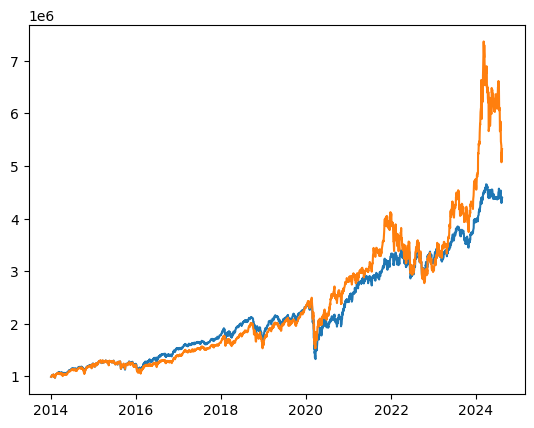

In [16]:
plt.plot(portfolio_ew[portfolio_ew["Ticker"] == "DIS"]["Date"], portfolio_ew[portfolio_ew["Ticker"] == "DIS"]["PORT_TOTAL_VAL_LAST"])
plt.plot(portfolio_ew_unbalanced[portfolio_ew_unbalanced["Ticker"] == "DIS"]["Date"], portfolio_ew_unbalanced[portfolio_ew_unbalanced["Ticker"] == "DIS"]["PORT_TOTAL_VAL_LAST"])
plt.show()